In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from keras.preprocessing.sequence import pad_sequences

import pandas as pd
import matplotlib as mpl
import matplotlib.pylab as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import keras.backend as K 

from keras.callbacks import EarlyStopping,ModelCheckpoint

from keras.utils import np_utils
from keras.models import Sequential, load_model

from keras.layers import BatchNormalization, Conv1D, LSTM,Input, Dense, Dropout,TimeDistributed, Flatten,MaxPooling1D
from keras.optimizers import Adam
from keras.models import Model

from keras.callbacks import ReduceLROnPlateau
from keras.applications.mobilenet import MobileNet, decode_predictions
from keras.applications.resnet50 import ResNet50, decode_predictions

from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, classification_report


import random

import ast
import os
import cv2
from collections import Counter

Using TensorFlow backend.


In [2]:
import winsound as ws

def beepsound():
    freq = 2000    # range : 37 ~ 32767
    dur = 1000     # ms
    ws.Beep(freq, dur) # winsound.Beep(frequency, duration)


# Data Preparation(1)

In [2]:
all_data = pd.read_pickle("new_true_split_data/dataset_1.pkl")

In [3]:
all_data2 = pd.read_pickle("new_true_split_data/dataset_2.pkl")

In [4]:
aa, bb = train_test_split(all_data2, test_size=0.2, shuffle = True,
                                random_state = 42,
                                stratify = all_data2["word"])

In [5]:
bb.reset_index(drop=True,inplace=True)

In [6]:
bb.shape

(100000, 6)

In [3]:
all_data.shape

(500000, 6)

In [7]:
word_lst = list(all_data2['word'].unique())

In [5]:
train2, test = train_test_split(all_data, test_size=0.3, shuffle = True,
                                random_state = 42,
                                stratify = all_data["word"])

In [6]:
Counter(train2["word"])

Counter({'wine bottle': 17500,
         'pond': 17500,
         'cake': 17500,
         'traffic light': 17500,
         'sea turtle': 17500,
         'carrot': 17500,
         'microphone': 17500,
         'snake': 17500,
         'octopus': 17500,
         'mermaid': 17500,
         'chandelier': 17500,
         'dog': 17500,
         'bat': 17500,
         'television': 17500,
         'light bulb': 17500,
         'computer': 17500,
         'pliers': 17500,
         'candle': 17500,
         'monkey': 17500,
         'couch': 17500})

In [7]:
train, valid=  train_test_split(train2, test_size=0.3, shuffle = True, 
                                random_state = 42,
                                stratify = train2["word"])

In [8]:
Counter(all_data["word"])

Counter({'wine bottle': 25000,
         'candle': 25000,
         'computer': 25000,
         'pond': 25000,
         'light bulb': 25000,
         'traffic light': 25000,
         'bat': 25000,
         'carrot': 25000,
         'snake': 25000,
         'dog': 25000,
         'monkey': 25000,
         'television': 25000,
         'microphone': 25000,
         'sea turtle': 25000,
         'couch': 25000,
         'cake': 25000,
         'mermaid': 25000,
         'chandelier': 25000,
         'octopus': 25000,
         'pliers': 25000})

In [9]:
print(train.shape)
print(valid.shape)
print(test.shape)

(245000, 6)
(105000, 6)
(150000, 6)


In [8]:
word_le = LabelEncoder()
word_le.fit(all_data2['word'])

LabelEncoder()

In [9]:
word_le.classes_

array(['bat', 'cake', 'candle', 'carrot', 'chandelier', 'computer',
       'couch', 'dog', 'light bulb', 'mermaid', 'microphone', 'monkey',
       'octopus', 'pliers', 'pond', 'sea turtle', 'snake', 'television',
       'traffic light', 'wine bottle'], dtype=object)

# Data Preparation(2)

* Input data 사용 가능하게 전처리([Kaggle](https://www.kaggle.com/kmader/quickdraw-baseline-lstm-reading-and-submission) 참조)

In [10]:
word_num = len(word_lst)
INPUT_DRAW = 200

In [11]:
def stroke_to_input(draw):
    
    if type(draw) != type([]):
        draw = eval(draw)
        
    # (x point, y point, order)의 형식으로 변환
    redraw_lst = []
    
    for i, (x,y) in enumerate(draw):
        for x2,y2 in zip(x,y):
            redraw_lst.append([x2,y2,i])
            
    # array로 변환
    redraw_arr = np.stack(redraw_lst)
    
    # order 전처리(새 stroke면 2, 아니면 1)
    redraw_arr[:,2] = [2]+([1] + np.diff(redraw_arr[:,2])).tolist()
    
    # 일정한 길이로 만들기 위해 pad_sequences 사용
    result = pad_sequences(redraw_arr.swapaxes(0,1),
                          maxlen = INPUT_DRAW,
                          padding = 'post').swapaxes(0,1)
    
    return result

In [12]:
size = 64
word_num = len(word_lst)
BASE_SIZE = 256

In [13]:
def reshape_draw(rs, size=256, lw=6):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for s in rs:
        for i in range(len(s[0]) - 1):
            _ = cv2.line(img, (s[0][i], s[1][i]), (s[0][i + 1], s[1][i + 1]), 255, lw)
#             print(_)

    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img

In [14]:
def drawing_make_array(df, size = size, lw = 6):
    x = np.zeros((len(df),size,size))
    for i, rs in enumerate(df.drawing.values):
        x[i] = reshape_draw(rs,size=size,lw=lw)
    x = x/255 # 정규화
    x = x.reshape((len(df),size,size,1)).astype(np.float32)
    return x

# 직접 test set 구성

In [15]:
test_df = pd.DataFrame()

### 1. Dog

In [27]:
raw_images = [[[102,65,52,74,140,193,205,184,141,105],[62,90,127,167,175,151,104,60,48,44]],
             [[71,29,14,27,59],[44,47,81,95,95]],
             [[181,219,244,242,214],[36,41,61,88,83]],
             [[92],[99]],[[168],[100]],
             [[132,122,120,137,140,133],[122,121,129,133,125,121]],
             [[95,121,125,128,131,138,152,155],[150,153,142,138,149,154,154,147]]]

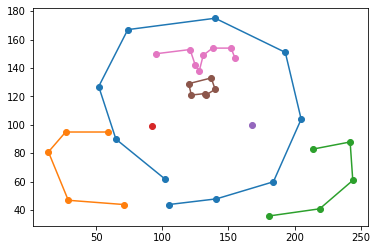

In [35]:
for i in range(len(raw_images)):
    plt.plot(raw_images[i][0], raw_images[i][1],'o-')
plt.show()

In [31]:
for i in range(len(raw_images)):
    tp = []
    for k in raw_images[i][1]:
        tp.append(255-k)
    print(tp)

[193, 165, 128, 88, 80, 104, 151, 195, 207, 211]
[211, 208, 174, 160, 160]
[219, 214, 194, 167, 172]
[156]
[155]
[133, 134, 126, 122, 130, 134]
[105, 102, 113, 117, 106, 101, 101, 108]


In [16]:
raw_images2 = [[[102,65,52,74,140,193,205,184,141,105],[193, 165, 128, 88, 80, 104, 151, 195, 207, 211]],
             [[71,29,14,27,59],[211, 208, 174, 160, 160]],
             [[181,219,244,242,214],[219, 214, 194, 167, 172]],
             [[92],[156]],[[168],[155]],
             [[132,122,120,137,140,133],[133, 134, 126, 122, 130, 134]],
             [[95,121,125,128,131,138,152,155],[105, 102, 113, 117, 106, 101, 101, 108]]]

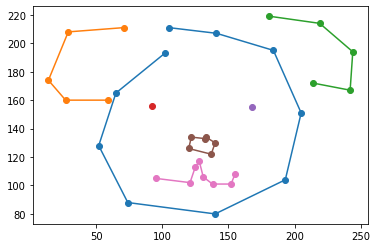

In [34]:
for i in range(len(raw_images2)):
    plt.plot(raw_images2[i][0], raw_images2[i][1],'o-')
plt.show()

In [17]:
tmp_d = str(raw_images2)

In [83]:
# test_df["drawing"] = [tmp_d]
# test_df["word"] = ['dog']

In [84]:
test_df

,drawing,word
0,"[[[102, 65, 52, 74, 140, 193, 205, 184, 141, 1...",dog


## 2. television

In [87]:
raw_images = [[[53,51,51,62,136,180,215,215,216,173,103,50],[72,108,149,168,168,165,168,110,65,49,50,51]],
             [[111,84,61],[58,40,23]],
             [[111,137,163],[60,47,37]],
             [[64,65,73,132,146,150,150,102,64],[94,137,154,154,154,91,78,73,71]],
              [[182,170,167,179,189,189],[74,77,95,98,91,77]]]

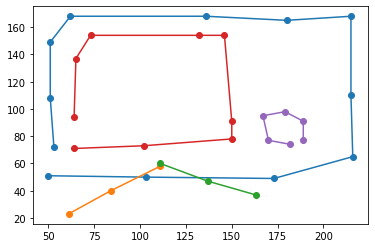

In [88]:
for i in range(len(raw_images)):
    plt.plot(raw_images[i][0], raw_images[i][1],'o-')
plt.show()

In [89]:
for i in range(len(raw_images)):
    tp = []
    for k in raw_images[i][1]:
        tp.append(255-k)
    print(tp)

[183, 147, 106, 87, 87, 90, 87, 145, 190, 206, 205, 204]
[197, 215, 232]
[195, 208, 218]
[161, 118, 101, 101, 101, 164, 177, 182, 184]
[181, 178, 160, 157, 164, 178]


In [18]:
raw_images2 = [[[53,51,51,62,136,180,215,215,216,173,103,50],[183, 147, 106, 87, 87, 90, 87, 145, 190, 206, 205, 204]],
             [[111,84,61],[197, 215, 232]],
             [[111,137,163],[195, 208, 218]],
             [[64,65,73,132,146,150,150,102,64],[161, 118, 101, 101, 101, 164, 177, 182, 184]],
              [[182,170,167,179,189,189],[181, 178, 160, 157, 164, 178]]]

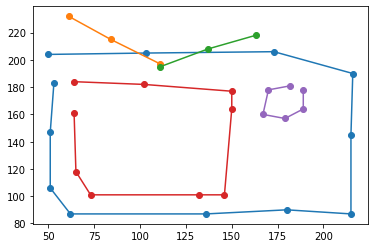

In [91]:
for i in range(len(raw_images2)):
    plt.plot(raw_images2[i][0], raw_images2[i][1],'o-')
plt.show()

In [19]:
tmp_t = str(raw_images2)

In [20]:
test_df["drawing"] = [tmp_d,tmp_t]
test_df["word"] = ['dog','television']

In [21]:
test_df

,drawing,word
0,"[[[102, 65, 52, 74, 140, 193, 205, 184, 141, 1...",dog
1,"[[[53, 51, 51, 62, 136, 180, 215, 215, 216, 17...",television


In [22]:
bb.loc[149998,"drawing"] = test_df.loc[0,"drawing"]
bb.loc[149998,"word"] =  test_df.loc[0,"word"]

C:\Users\julia\Desktop\tf\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [23]:
bb.loc[149999,"drawing"] = test_df.loc[1,"drawing"]
bb.loc[149999,"word"] =  test_df.loc[1,"word"]

In [24]:
test_X = np.stack(bb["drawing"].map(stroke_to_input))
test_y = to_categorical(word_le.transform(bb['word'].values))

In [25]:
test_X2 = drawing_make_array(bb, size)
test_y2 = to_categorical(word_le.transform(bb['word'].values))

In [26]:
print("Test shape:",test_X.shape)
print("Test2 shape:",test_X2.shape)

Test shape: (100002, 200, 3)
Test2 shape: (100002, 64, 64, 1)


In [15]:
test_X = np.stack(test["drawing"].map(stroke_to_input))
test_y = to_categorical(word_le.transform(test['word'].values))

In [19]:
test_X2 = drawing_make_array(test, size)
test_y2 = to_categorical(word_le.transform(test['word'].values))

In [23]:
print("Test shape:",test_X.shape)
print("Test2 shape:",test_X2.shape)

Test shape: (150000, 200, 3)
Test2 shape: (150000, 64, 64, 1)


In [51]:
beepsound()

# Modeling

In [27]:
STEPS= 200
batch = 100
epochs = 50

In [28]:
model_1 = load_model('1225_cnnlstm/1225_cnnlstm_3.h5')

In [29]:
model_1.evaluate(test_X, test_y, batch_size=1)

100002/100002 [==============================] - 1540s 15ms/step


[0.24533615967468977, 0.9238515496253967]

In [30]:
pred_y1 = model_1.predict(test_X)

In [31]:
ppp1 = np.argmax(pred_y1,1)
ttt = np.argmax(test_y,1)

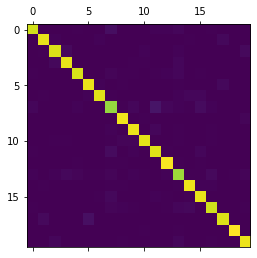

In [32]:
plt.matshow(confusion_matrix(ttt,ppp1))

In [33]:
print(classification_report(ttt, ppp1, 
                            target_names = [x for x in word_le.classes_]))

               precision    recall  f1-score   support

          bat       0.94      0.91      0.92      5000
         cake       0.94      0.94      0.94      5000
       candle       0.92      0.92      0.92      5000
       carrot       0.93      0.94      0.94      5000
   chandelier       0.94      0.91      0.93      5000
     computer       0.93      0.94      0.94      5000
        couch       0.95      0.93      0.94      5000
          dog       0.83      0.82      0.82      5001
   light bulb       0.93      0.95      0.94      5000
      mermaid       0.93      0.94      0.94      5000
   microphone       0.96      0.93      0.94      5000
       monkey       0.89      0.92      0.91      5000
      octopus       0.93      0.96      0.95      5000
       pliers       0.84      0.83      0.84      5000
         pond       0.92      0.95      0.93      5000
   sea turtle       0.91      0.94      0.92      5000
        snake       0.93      0.90      0.92      5000
   televi

In [34]:
model_2 = load_model('1224_resnet/1224_resnet_3.h5')

In [35]:
model_2.evaluate(test_X2, test_y2)

100002/100002 [==============================] - 245s 2ms/step


[0.2706163377116982, 0.9371112585067749]

In [36]:
pred_y2 = model_2.predict(test_X2, batch_size= batch)

In [37]:
ppp2 = np.argmax(pred_y2,1)

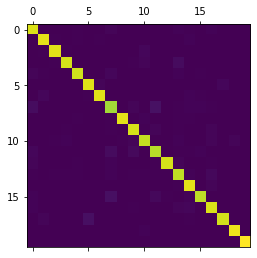

In [38]:
plt.matshow(confusion_matrix(ttt,ppp2))

In [39]:
print(classification_report(ttt, ppp2, 
                            target_names = [x for x in word_le.classes_]))

               precision    recall  f1-score   support

          bat       0.89      0.95      0.92      5000
         cake       0.95      0.96      0.96      5000
       candle       0.97      0.96      0.96      5000
       carrot       0.96      0.94      0.95      5000
   chandelier       0.95      0.93      0.94      5000
     computer       0.94      0.95      0.95      5000
        couch       0.97      0.95      0.96      5000
          dog       0.85      0.86      0.86      5001
   light bulb       0.98      0.96      0.97      5000
      mermaid       0.91      0.94      0.93      5000
   microphone       0.93      0.91      0.92      5000
       monkey       0.89      0.89      0.89      5000
      octopus       0.97      0.94      0.95      5000
       pliers       0.88      0.90      0.89      5000
         pond       0.90      0.96      0.93      5000
   sea turtle       0.95      0.90      0.92      5000
        snake       0.91      0.94      0.93      5000
   televi

In [40]:
pred_y1.shape

(100002, 20)

In [41]:
pred_y2.shape

(100002, 20)

In [42]:
pred_Y = pred_y1+pred_y2

In [43]:
PPP = np.argmax(pred_Y,1)

In [44]:
PPP

array([ 2, 17, 15, ...,  5, 19, 19], dtype=int64)

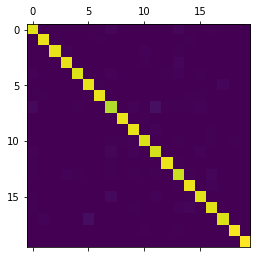

In [45]:
plt.matshow(confusion_matrix(ttt,PPP))

In [46]:
print(classification_report(ttt, PPP, 
                            target_names = [x for x in word_le.classes_]))

               precision    recall  f1-score   support

          bat       0.93      0.96      0.94      5000
         cake       0.97      0.97      0.97      5000
       candle       0.98      0.97      0.97      5000
       carrot       0.97      0.97      0.97      5000
   chandelier       0.97      0.95      0.96      5000
     computer       0.95      0.96      0.96      5000
        couch       0.98      0.97      0.97      5000
          dog       0.90      0.88      0.89      5001
   light bulb       0.98      0.97      0.97      5000
      mermaid       0.95      0.97      0.96      5000
   microphone       0.96      0.95      0.96      5000
       monkey       0.92      0.94      0.93      5000
      octopus       0.98      0.97      0.97      5000
       pliers       0.91      0.92      0.91      5000
         pond       0.95      0.97      0.96      5000
   sea turtle       0.96      0.95      0.95      5000
        snake       0.94      0.95      0.95      5000
   televi

In [52]:
a = [1,2,3,4]

In [53]:
a[-2:]

[3, 4]

In [50]:
ppp2[-2:]

array([19, 19], dtype=int64)

In [51]:
ppp1[-2:]

array([4, 4], dtype=int64)

In [54]:
PPP[-2:]

array([19, 19], dtype=int64)

In [55]:
ttt[-2:]

array([ 7, 17], dtype=int64)

In [77]:
ppp1

array([ 3,  5,  7, ..., 14,  5,  0], dtype=int64)

In [78]:
ttt

array([3, 5, 7, ..., 1, 5, 0], dtype=int64)

In [101]:
pp1_idx = []
for i in range(len(ppp1)):
    if ppp1[i] != ttt[i]:
        pp1_idx.append(i)

In [102]:
len(p1)

11562

In [103]:
pp2_idx = []
for i in range(len(ppp2)):
    if ppp2[i] != ttt[i]:
        pp2_idx.append(i)

In [104]:
len(p2)

9638

In [126]:
pp_idx = []
for i in range(len(PPP)):
    if PPP[i] != ttt[i]:
        pp_idx.append(i)

In [128]:
len(pp_idx)

6594

In [129]:
pp_idx

[30,
 71,
 80,
 120,
 188,
 195,
 200,
 223,
 243,
 259,
 356,
 358,
 379,
 411,
 429,
 433,
 464,
 481,
 495,
 502,
 534,
 546,
 548,
 563,
 564,
 573,
 600,
 605,
 608,
 615,
 630,
 637,
 649,
 650,
 653,
 692,
 705,
 736,
 741,
 760,
 763,
 764,
 816,
 834,
 838,
 847,
 870,
 915,
 926,
 930,
 932,
 938,
 943,
 983,
 986,
 989,
 1002,
 1028,
 1043,
 1070,
 1080,
 1085,
 1099,
 1120,
 1130,
 1140,
 1172,
 1193,
 1225,
 1258,
 1275,
 1291,
 1306,
 1325,
 1327,
 1339,
 1429,
 1431,
 1529,
 1538,
 1564,
 1575,
 1582,
 1588,
 1593,
 1604,
 1608,
 1646,
 1679,
 1713,
 1740,
 1788,
 1810,
 1812,
 1818,
 1826,
 1839,
 1842,
 1847,
 1881,
 1885,
 1942,
 1971,
 1983,
 1994,
 2105,
 2107,
 2172,
 2190,
 2200,
 2237,
 2259,
 2285,
 2333,
 2355,
 2418,
 2429,
 2444,
 2483,
 2486,
 2490,
 2499,
 2503,
 2569,
 2582,
 2652,
 2672,
 2694,
 2734,
 2762,
 2773,
 2775,
 2829,
 2839,
 2858,
 2878,
 2881,
 2884,
 2886,
 2888,
 2902,
 2915,
 2926,
 2931,
 2937,
 2953,
 2967,
 2994,
 2999,
 3037,
 3062,
 3

In [130]:
inter_idx

[30,
 80,
 120,
 154,
 195,
 200,
 223,
 356,
 358,
 429,
 433,
 464,
 495,
 502,
 564,
 600,
 605,
 630,
 649,
 653,
 692,
 705,
 741,
 764,
 915,
 926,
 932,
 943,
 989,
 1043,
 1085,
 1099,
 1130,
 1140,
 1172,
 1225,
 1275,
 1306,
 1429,
 1528,
 1529,
 1564,
 1575,
 1582,
 1588,
 1593,
 1604,
 1608,
 1646,
 1788,
 1812,
 1818,
 1839,
 1842,
 1847,
 1881,
 1885,
 1942,
 1994,
 2107,
 2200,
 2237,
 2333,
 2355,
 2418,
 2429,
 2483,
 2490,
 2499,
 2503,
 2569,
 2652,
 2734,
 2762,
 2775,
 2858,
 2881,
 2888,
 2926,
 2931,
 2999,
 3037,
 3062,
 3068,
 3152,
 3160,
 3209,
 3344,
 3485,
 3537,
 3580,
 3588,
 3627,
 3634,
 3711,
 3721,
 3722,
 3731,
 3775,
 3798,
 3815,
 3896,
 3982,
 3989,
 4000,
 4086,
 4174,
 4288,
 4292,
 4341,
 4378,
 4402,
 4456,
 4462,
 4483,
 4497,
 4559,
 4604,
 4612,
 4667,
 4689,
 4702,
 4719,
 4738,
 4802,
 4804,
 4818,
 4821,
 4850,
 4928,
 4972,
 5060,
 5084,
 5108,
 5129,
 5242,
 5246,
 5277,
 5293,
 5312,
 5359,
 5361,
 5375,
 5423,
 5436,
 5437,
 5440,
 5

In [107]:
inter_idx = list(set(pp1_idx) & set(pp2_idx))

In [138]:
inter_idx.sort()

In [139]:
len(inter_idx)

3883

In [114]:
ppp1[inter_idx[0]]

0

In [125]:
ttt[inter_idx[0]]

7

In [135]:
target_idx = list(set(inter_idx) - set(pp_idx))

In [136]:
target_idx.sort()

In [178]:
len(target_idx)

52

In [65]:
idx = 0
for k in pred_y1[-2]:
    print(idx, round(k,3), word_le.classes_[idx])
    idx += 1

0 0.001 bat
1 0.021 cake
2 0.001 candle
3 0.011 carrot
4 0.72 chandelier
5 0.069 computer
6 0.003 couch
7 0.026 dog
8 0.003 light bulb
9 0.001 mermaid
10 0.002 microphone
11 0.0 monkey
12 0.0 octopus
13 0.009 pliers
14 0.004 pond
15 0.004 sea turtle
16 0.001 snake
17 0.122 television
18 0.001 traffic light
19 0.001 wine bottle


In [66]:
idx = 0
for k in pred_y2[-2]:
    print(idx, round(k,3), word_le.classes_[idx])
    idx += 1

0 0.0 bat
1 0.0 cake
2 0.0 candle
3 0.0 carrot
4 0.0 chandelier
5 0.0 computer
6 0.0 couch
7 0.0 dog
8 0.0 light bulb
9 0.0 mermaid
10 0.0 microphone
11 0.0 monkey
12 0.0 octopus
13 0.0 pliers
14 0.0 pond
15 0.0 sea turtle
16 0.0 snake
17 0.0 television
18 0.0 traffic light
19 1.0 wine bottle


In [64]:
idx = 0
for k in pred_Y[-1]:
    print(idx, round(k,3), word_le.classes_[idx])
    idx += 1

0 0.0 bat
1 0.003 cake
2 0.0 candle
3 0.013 carrot
4 0.425 chandelier
5 0.29 computer
6 0.003 couch
7 0.019 dog
8 0.006 light bulb
9 0.0 mermaid
10 0.002 microphone
11 0.0 monkey
12 0.001 octopus
13 0.008 pliers
14 0.001 pond
15 0.005 sea turtle
16 0.0 snake
17 0.223 television
18 0.002 traffic light
19 1.001 wine bottle


In [60]:
pred_y1[-1]

array([2.5486536e-04, 3.0175846e-03, 1.1960301e-04, 1.2662814e-02,
       4.2450112e-01, 2.8996137e-01, 2.5722554e-03, 1.8832657e-02,
       5.8219465e-03, 5.0084032e-05, 1.6801091e-03, 3.6757760e-05,
       5.4587907e-04, 8.0404487e-03, 1.2511888e-03, 5.0523086e-03,
       3.2677414e-04, 2.2281049e-01, 1.6710965e-03, 7.9062453e-04],
      dtype=float32)

In [206]:
pp1_name = []
for i in range(len(pp1_idx)):
    pp1_name.append(word_le.classes_[ppp1[pp1_idx[i]]])

In [207]:
pp1_dict = Counter(pp1_name)

pp1_df = pd.DataFrame()

pp1_df['Key'] = pp1_dict.keys()
pp1_df['Values'] = pp1_dict.values()

In [208]:
pp1_df.sort_values(["Values"],ascending=False, inplace=True)

In [209]:
pp1_df.reset_index(inplace=True, drop=True)

In [210]:
pp1_df

,Key,Values
0,dog,1301
1,pliers,1265
2,monkey,893
3,sea turtle,742
4,pond,607
5,mermaid,582
6,candle,553
7,carrot,540
8,snake,536
9,octopus,506


In [211]:
pp2_name = []
for i in range(len(pp2_idx)):
    pp2_name.append(word_le.classes_[ppp2[pp2_idx[i]]])

In [212]:
pp2_dict = Counter(pp2_name)

pp2_df = pd.DataFrame()

pp2_df['Key'] = pp2_dict.keys()
pp2_df['Values'] = pp2_dict.values()

In [213]:
pp2_df.sort_values(["Values"],ascending=False, inplace=True)

In [214]:
pp2_df.reset_index(inplace=True, drop=True)

In [215]:
pp2_df

,Key,Values
0,dog,1049
1,pliers,994
2,monkey,899
3,bat,840
4,pond,752
5,snake,736
6,mermaid,718
7,microphone,513
8,computer,416
9,cake,409


In [184]:
pp_name = []
for i in range(len(pp_idx)):
    pp_name.append(word_le.classes_[PPP[pp_idx[i]]])

In [186]:
pp_dict = Counter(pp_name)

In [202]:
pp_df = pd.DataFrame()

pp_df['Key'] = pp_dict.keys()
pp_df['Values'] = pp_dict.values()

In [203]:
pp_df.sort_values(["Values"],ascending=False, inplace=True)

In [204]:
pp_df.reset_index(inplace=True, drop=True)

In [205]:
pp_df

,Key,Values
0,dog,760
1,pliers,702
2,monkey,557
3,bat,532
4,snake,469
5,pond,430
6,mermaid,409
7,computer,352
8,sea turtle,326
9,microphone,292


In [140]:
ppp1[target_idx[0]]

7

In [141]:
ppp2[target_idx[0]]

13

In [143]:
PPP[target_idx[0]]

11

In [142]:
ttt[target_idx[0]]

11

In [154]:
idx = 0
for k in pred_y1[target_idx[0]]:
    print(idx, round(k,3), word_le.classes_[idx])
    idx += 1

0 0.002 bat
1 0.0 cake
2 0.0 candle
3 0.0 carrot
4 0.0 chandelier
5 0.0 computer
6 0.0 couch
7 0.499 dog
8 0.0 light bulb
9 0.024 mermaid
10 0.001 microphone
11 0.466 monkey
12 0.001 octopus
13 0.002 pliers
14 0.0 pond
15 0.004 sea turtle
16 0.0 snake
17 0.0 television
18 0.0 traffic light
19 0.0 wine bottle


In [155]:
idx = 0
for k in pred_y2[target_idx[0]]:
    print(idx, round(k,3), word_le.classes_[idx])
    idx += 1

0 0.013 bat
1 0.003 cake
2 0.017 candle
3 0.12 carrot
4 0.014 chandelier
5 0.002 computer
6 0.001 couch
7 0.064 dog
8 0.004 light bulb
9 0.246 mermaid
10 0.066 microphone
11 0.12 monkey
12 0.019 octopus
13 0.27 pliers
14 0.005 pond
15 0.001 sea turtle
16 0.029 snake
17 0.006 television
18 0.002 traffic light
19 0.0 wine bottle


In [156]:
idx = 0
for k in pred_Y[target_idx[0]]:
    print(idx, round(k,3), word_le.classes_[idx])
    idx += 1

0 0.014 bat
1 0.003 cake
2 0.017 candle
3 0.12 carrot
4 0.015 chandelier
5 0.002 computer
6 0.001 couch
7 0.563 dog
8 0.004 light bulb
9 0.269 mermaid
10 0.068 microphone
11 0.586 monkey
12 0.02 octopus
13 0.272 pliers
14 0.005 pond
15 0.005 sea turtle
16 0.029 snake
17 0.006 television
18 0.003 traffic light
19 0.0 wine bottle


In [115]:
ppp2[inter_idx[0]]

15

In [116]:
ttt[inter_idx[0]]

7

##  이미지 그리기

In [163]:
eval(test.loc[target_idx[0],"drawing"])

[[[40,
   45,
   37,
   1,
   0,
   8,
   15,
   28,
   84,
   109,
   127,
   132,
   136,
   136,
   133,
   125,
   78,
   62,
   58,
   61,
   59,
   48,
   32],
  [7,
   82,
   92,
   120,
   162,
   226,
   245,
   251,
   255,
   248,
   236,
   223,
   147,
   121,
   103,
   93,
   83,
   75,
   62,
   5,
   1,
   0,
   11]]]

In [227]:
tt = test.reset_index(drop=True)

television


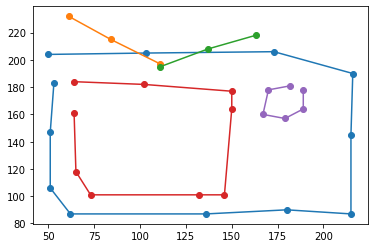

In [57]:
ii = 0
raw_images = eval(bb.loc[149999,"drawing"])

k = 0
print(bb.loc[149999,"word"])
for i in range(len(raw_images)):
    plt.plot(raw_images[i][0], raw_images[i][1],'o-')
plt.show()

dog


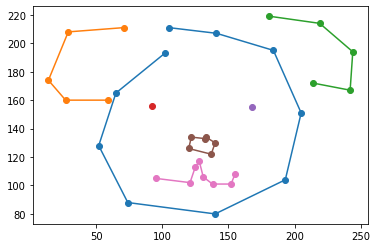

In [58]:
ii = 0
raw_images = eval(bb.loc[149998,"drawing"])

k = 0
print(bb.loc[149998,"word"])
for i in range(len(raw_images)):
    plt.plot(raw_images[i][0], raw_images[i][1],'o-')
plt.show()

In [171]:
def get_Xy(in_df):
    X = np.stack(in_df['drawing'], 0)
    y = to_categorical(word_encoder.transform(in_df['word'].values))
    return X, y
train_X, train_y = get_Xy(train_df)
valid_X, valid_y = get_Xy(valid_df)
test_X, test_y = get_Xy(test_df)
print(train_X.shape)

NameError: name 'train_df' is not defined

In [108]:

stroke_read_model = Sequential()
stroke_read_model.add(BatchNormalization(input_shape = (None,)))
# filter count and length are taken from the script https://github.com/tensorflow/models/blob/master/tutorials/rnn/quickdraw/train_model.py
stroke_read_model.add(Conv1D(48, (5,)))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(Conv1D(64, (5,)))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(Conv1D(96, (3,)))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(LSTM(128, return_sequences = True))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(LSTM(128, return_sequences = False))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(Dense(512))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(Dense(len(word_encoder.classes_), activation = 'softmax'))
stroke_read_model.compile(optimizer = 'adam', 
                          loss = 'categorical_crossentropy', 
                          metrics = ['categorical_accuracy', top_3_accuracy])
stroke_read_model.summary()

ValueError: Axis -1 of input tensor should have a defined dimension but the layer received an input with shape (None, None).